<a href="https://colab.research.google.com/github/s-c-soma/deep_context_graph/blob/main/code/StatementChecker_KnowledgeGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two variation: 
1. summarize ->graph :: .buildGraph(.summarize(text))
2. distillation -> graph :: .buildGraph(.distill(text))


# **Env Setup**


In [1]:


# Mount google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=False)


# create folder to write data to
#CIS545_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS545_2020')
#HOMEWORK_FOLDER=os.path.join(CIS545_FOLDER, 'Project')
#os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

Mounted at /content/drive


In [ ]:
!ls '/content/drive/Shared drives/1DeepContextGraph/1DeepContextGraph'

code  documents


In [2]:
file_path = '/content/drive/Shared drives/1DeepContextGraph/1DeepContextGraph/code/data/'

# Library

In [1]:
!pip install sentence-transformers

     |████████████████████████████████| 81kB 2.9MB/s 
     |████████████████████████████████| 2.1MB 6.2MB/s 
     |████████████████████████████████| 1.2MB 52.2MB/s 
     |████████████████████████████████| 901kB 41.6MB/s 
     |████████████████████████████████| 3.3MB 44.0MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=616565f05d26f2de220cb7d5d1e940a40348a80590956069dbd65682d53bc462
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


In [2]:
!pip install LexRank

     |████████████████████████████████| 71kB 2.6MB/s 


In [3]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
#import lexrank.degree_centrality_scores

from lexrank import STOPWORDS, LexRank
from path import Path


In [5]:
import json
import os
# For caculating approximate time to process notebook (IGNORE)
import datetime
datetime.datetime.now()
import argparse
import pandas as pd
import numpy as np
import operator
import pickle as pkl 
import matplotlib.pyplot as plt
import nltk as nl
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import ParameterGrid
import statistics
import random
import warnings
from string import punctuation
from matplotlib import pyplot
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
import nltk
import re
import io
import requests
import time
import gensim
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import nltk.sentiment
from sentence_transformers import SentenceTransformer, util
import numpy as np
import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Load Data

In [7]:
data_fox_claim = pd.read_csv(file_path+'/fox_claim_news_processed.csv',low_memory=False)
#data_all_news = pd.read_csv(file_path+'/statement_checker_all.csv',low_memory=False)
data_polifact = pd.read_csv(file_path+'/political_fact_checker_processed.csv',low_memory=False)


In [8]:
data_fox_claim.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'link', 'published', 'title', 'text',
       'site', 'text_distilled', 'topics', 'named_entity_recognition',
       'top_10_freq_word', 'pasts_of_speech'],
      dtype='object')

In [9]:
data_polifact.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'sources', 'urls', 'title', 'summaries',
       'dates', 'ratings', 'text', 'authors', 'publishdate', 'relatedlinks',
       'claims', 'text_distilled', 'topics', 'named_entity_recognition',
       'top_10_freq_word', 'pasts_of_speech'],
      dtype='object')

In [10]:
data_fox_claim['Unnamed: 0'][1]

1

In [11]:
data_fox_claim = data_fox_claim.rename({'Unnamed: 0': 'documentId'}, axis='columns')
data_polifact = data_polifact.rename({'Unnamed: 0': 'documentId'}, axis='columns')

# Methods

## Lemmatization
  
First, the raw words must be converted to root forms.  

In [12]:
def lemmatize(tokenized_words):
  text = [nltk.WordNetLemmatizer().lemmatize(word) for word in tokenized_words]
  return text


## Removing Stop words



In [13]:
english_stopwords = set(stopwords.words('english') + list(punctuation) + [''])

def remove_stopwords(tokenized_words):
  text = [word for word in tokenized_words if word not in english_stopwords]
  return text


## Custom Filtering

Some of the one or two-letter words from the tokenized words are also removed to further cleanse the raw text. 

In [14]:
whitelist = set(['ai', 'ax', 'ca', 'eu', 'go', 'io', 'la', 'ox', 'us', 'uk', 
                 'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 
                 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi',
                 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny',
                 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn',
                 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy' ])
def remove_too_short(tokenized_words):
  text = [word for word in tokenized_words if (len(word) >= 3 or word not in whitelist) ]
  return text

## LDA Analysis


In [15]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

def topics(tokenized_words):
    d = Dictionary([tokenized_words])
    c = [d.doc2bow(tokenized_words)]
    m = LdaModel(c, num_topics=1, id2word=d)
    return list(m.print_topics(num_words=2))
  


## Topics as Simple List of Words

A list of topic terms is compiled as show below. The coefficients in front of each word are dropped as part of simplification. The assumption is that the top two words comprising the topic, are both significant enough to be treated equally. It is important that the goal is to build a reliable prediction model. While there is a risk of oversimplification, if the final model results in a poor accuracy score, the coefficient can always be reintroduced here.

In [16]:
def parseTopics(topics):
   output = []
   words = topics[0][1].split( '+' )
   for word in words:
       output.append( word.split('*')[1].replace( '"', '' ) )
   return output

# Information extraction and knowledge graphs

* https://programmerbackpack.com/python-nlp-tutorial-information-extraction-and-knowledge-graphs/
* https://github.com/bdmarius/python-knowledge-graph

## Methods

In [6]:
def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6), dpi=80)
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()

## Example and Experiment

In [ ]:
text = "London is the capital and largest city of England and the United Kingdom. Standing on the River " \
           "Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to " \
           "the North Sea, London has been a major settlement for two millennia. " \
           "Londinium was founded by the Romans. The City of London, " \
           "London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as " \
           "the Square Mile − retains boundaries that follow closely its medieval limits." \
           "The City of Westminster is also an Inner London borough holding city status. " \
           "Greater London is governed by the Mayor of London and the London Assembly." \
           "London is located in the southeast of England." \
           "Westminster is located in London." \
           "London is the biggest city in Britain. London has a population of 7,172,036."


In [31]:
body = """ The Chrysler Building, the famous art deco New York skyscraper, will be
 sold for a small fraction of its previous sales price. The building sold fairly 
 quickly after being publicly placed on the market only two months ago. The incentive 
 to sell the building at such a huge loss was due to the soaring rent the owners pay to 
 Cooper Union, a New York college, for the land under the building.' Still the building is 
among the best known in the city, even to people who have never been to New York. """

In [10]:
body = summary
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))

In -> prep
a -> det
self -> npadvmod
- -> punct
published -> amod
2015 -> nummod
autobiography -> pobj
, -> punct
Mellon -> nsubj
called -> ROOT
social -> amod
safety -> nmod
net -> amod
programs -> dobj
“ -> punct
Slavery -> compound
Redux -> appos
, -> punct
” -> punct
adding -> advcl
: -> punct
“ -> punct
For -> prep
delivering -> pcomp
their -> poss
votes -> dobj
in -> prep
the -> det
Federal -> compound
Elections -> pobj
, -> punct
they -> nsubjpass
are -> auxpass
awarded -> ccomp
with -> prep
yet -> advmod
more -> amod
and -> cc
more -> conj
freebies -> pobj
: -> punct
food -> compound
stamps -> appos
, -> punct
cell -> compound
phones -> conj
, -> punct
WIC -> compound
payments -> conj
, -> punct
Obamacare -> conj
, -> punct
and -> cc
on -> conj
, -> punct
and -> cc
on -> conj
, -> punct
and -> cc
on -> conj
. -> punct
Mellon they , publish call social net more , autobiography programs votes Elections freebies
Advertisement -> nmod


 -> 
Story -> nsubj
continues -> ROOT
below -

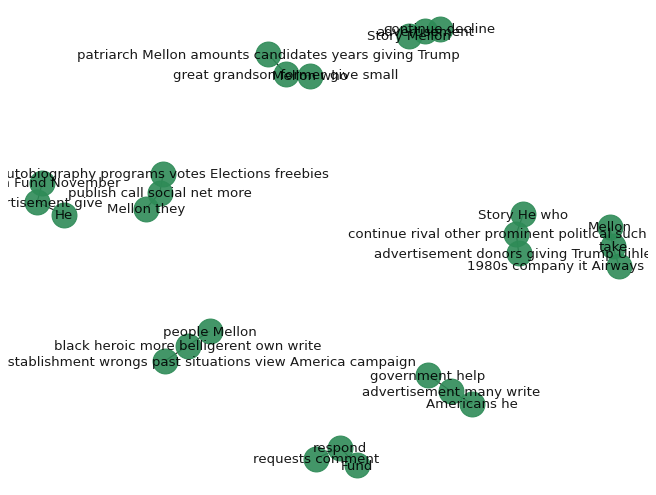

In [11]:
printGraph(triples)  

## Knowledge graph FoxClaim

In [38]:
data_fox_claim.head(1)

,documentId,Unnamed: 0.1,link,published,title,text,site,text_distilled,topics,named_entity_recognition,top_10_freq_word,pasts_of_speech
0,0,0,https://www.foxnews.com/us/violent-crime-los-a...,2021-04-15T22:33:38,"Murders in Los Angeles up nearly 200%, violent...",Murders in Los Angeles County have spiked near...,foxnews,"['murder', 'los', 'angeles', 'nearly', '200', ...","['angeles ', 'crime']","[(Raphael, 'PERSON'), (Warnock, 'PERSON'), (re...","[('los', 5), ('angeles', 5), ('crime', 5), ('f...","[('Murders', 'NNS'), ('Los', 'NNP'), ('Angeles..."


In [39]:
data_fox_claim.columns

Index(['documentId', 'Unnamed: 0.1', 'link', 'published', 'title', 'text',
       'site', 'text_distilled', 'topics', 'named_entity_recognition',
       'top_10_freq_word', 'pasts_of_speech'],
      dtype='object')

In [ ]:
body = data_fox_claim['title'][0]
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))

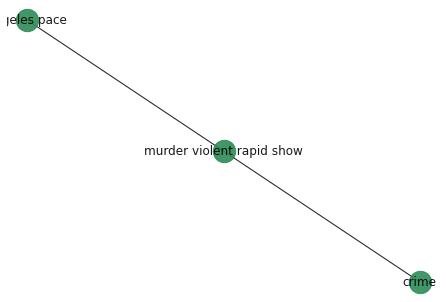

In [45]:
printGraph(triples) 

## Knowledge graph Politifact

In [41]:
data_polifact.head(1)

,documentId,Unnamed: 0.1,sources,urls,title,summaries,dates,ratings,text,authors,publishdate,relatedlinks,claims,text_distilled,topics,named_entity_recognition,top_10_freq_word,pasts_of_speech
0,0,0,politifact,http://www.politifact.com/factchecks/2021/mar/...,\nSays Deborah Birx “traveled a great distance...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,2021-03-29,half-true,\nFormer President Donald Trump didn’t appreci...,Jon Greenberg,2021-03-30,['https://www.cnn.com/2021/03/29/health/pandem...,"National,Coronavirus,Donald Trump","['say', 'deborah', 'birx', 'traveled', 'great'...","['birx ', 'said']","[(Donald, 'PERSON'), (Trump, 'PERSON'), (Biden...","[('birx', 22), ('said', 12), ('family', 10), (...","[('Former', 'NNP'), ('President', 'NNP'), ('Do..."


In [37]:
data_polifact.columns

Index(['documentId', 'Unnamed: 0.1', 'sources', 'urls', 'title', 'summaries',
       'dates', 'ratings', 'text', 'authors', 'publishdate', 'relatedlinks',
       'claims', 'text_distilled', 'topics', 'named_entity_recognition',
       'top_10_freq_word', 'pasts_of_speech'],
      dtype='object')

In [54]:
body = data_polifact['title'][0]
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))

Says -> ROOT
Deborah -> compound
Birx -> nsubj
“ -> punct
traveled -> ccomp
a -> det
great -> amod
distance -> dobj
to -> aux
see -> advcl
her -> poss
family -> dobj
for -> prep
Thanksgiving -> pobj
, -> punct
only -> advmod
to -> aux
have -> advcl
them -> nsubj
call -> ccomp
the -> det
police -> dobj
and -> cc
turn -> conj
her -> dobj
in -> prt
. -> punct
Birx them , say great , distance family Thanksgiving police her
She -> nsubj
then -> advmod
... -> punct
resigned -> ROOT
. -> punct
” -> punct
She , resign , 
 ,  , 


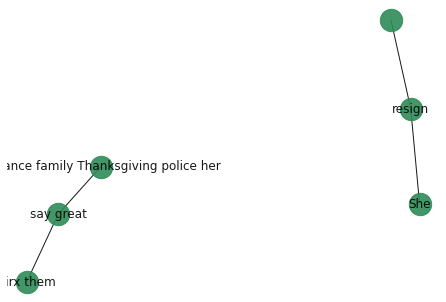

In [55]:
printGraph(triples) 

# Use Case: Political Donation Knowledge Graph for Trump

* news: 
https://www.washingtonpost.com/politics/timothy-mellon-top-donor-to-trump-super-pac-used-racial-stereotypes-to-describe-african-americans-in-his-autobiography/2020/06/18/89206c5a-a742-11ea-b619-3f9133bbb482_story.html

* ref: 
https://programmerbackpack.com/python-nlp-tutorial-information-extraction-and-knowledge-graphs/

In [7]:
!pip install newspaper3k

     |████████████████████████████████| 215kB 4.3MB/s 
     |████████████████████████████████| 7.4MB 32.5MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 92kB 9.9MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-cp37-none-any.whl size=13538 sha256=cb5b839bc100195d1f48d3d77d24d18389cf799a10eb37d3f01276f0ea5b1f7f
  Stored in directory: /root/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c7710628e91b8b0dc0f02
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-cp37-none-any.whl size=3358 sha256=ed9e26d4af763b7196b733a793ce42c8a94468e59aea3a4a0c7ba22888fd33f3
  Stored in directory: /root/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c7575424cfd3340f40ed
  Created wheel for jieba3k: filename=jieba3k-0.35.1-cp37-none-any.whl size=7398406 sha256=0cb3e9c17751cc9ae65f9d0381a1b6ea554d93f2836b12758d18599cd0b768ae
  Stored in directory: /root/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35d

## Get Text
https://analyticsindiamag.com/hands-on-guide-to-extractive-text-summarization-with-bertsum/

In [8]:
from newspaper import fulltext
import requests
article_url="https://www.washingtonpost.com/politics/timothy-mellon-top-donor-to-trump-super-pac-used-racial-stereotypes-to-describe-african-americans-in-his-autobiography/2020/06/18/89206c5a-a742-11ea-b619-3f9133bbb482_story.html "
article = fulltext(requests.get(article_url).text)
print(article)

In a self-published 2015 autobiography, Mellon called social safety net programs “Slavery Redux,” adding: “For delivering their votes in the Federal Elections, they are awarded with yet more and more freebies: food stamps, cell phones, WIC payments, Obamacare, and on, and on, and on. The largess is funded by the hardworking folks, fewer and fewer in number, who are too honest or too proud to allow themselves to sink into this morass.”

Advertisement

Story continues below advertisement

Mellon declined to comment.

The Wyoming-based donor, whose family fortune dates to the Gilded Age, gave his first major pro-Trump donation in April, with a $10 million check to America First Action, the main super PAC supporting the president’s reelection. His donations are the biggest known contributions to the group by far, and he is also a top donor to GOP congressional super PACs, according to campaign finance records.

America First Action, a super PAC chaired by Linda McMahon, former head of the 

## Get Summary from Text

In [9]:
## computed using my BERT Model Summarization
summary = '''
In a self-published 2015 autobiography, Mellon called social safety net programs “Slavery Redux,” adding: “For delivering their votes in the Federal Elections, they are awarded with yet more and more freebies: food stamps, cell phones, WIC payments, Obamacare, and on, and on, and on. Advertisement

Story continues below advertisement

Mellon declined to comment. Mellon, who is the great-grandson of Mellon family patriarch and banker Thomas Mellon, and grandson of Andrew W. Mellon, the former Treasury Department secretary, had given smaller amounts to state and federal GOP candidates for years, but ramped up his giving under Trump, campaign finance records show. Story continues below advertisement

He now rivals other prominent donors who have increased their political giving under Trump, such as shipping supplies magnate Richard Uihlein and Stephen Schwarzman, the Blackstone chairman and chief executive. Black people, in spite of heroic efforts by the ‘Establishment’ to right the wrongs of the past, became even more belligerent and unwilling to pitch in to improve their own situations,” Mellon wrote, describing his view of America during Reagan’s 1984 reelection campaign. Advertisement

Two decades later, too many Americans are still relying on the government for help, he wrote. In the 1980s, Mellon took over a rail company called Guilford Transportation Industries and rebranded it after purchasing Pan Am Airways from bankruptcy in the 1990s. Advertisement

He gave another $10 million to the Congressional Leadership Fund in November 2019. The Congressional Leadership Fund did not respond to requests for comment.'''

## Create Graph

In [ ]:
body = summary
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))

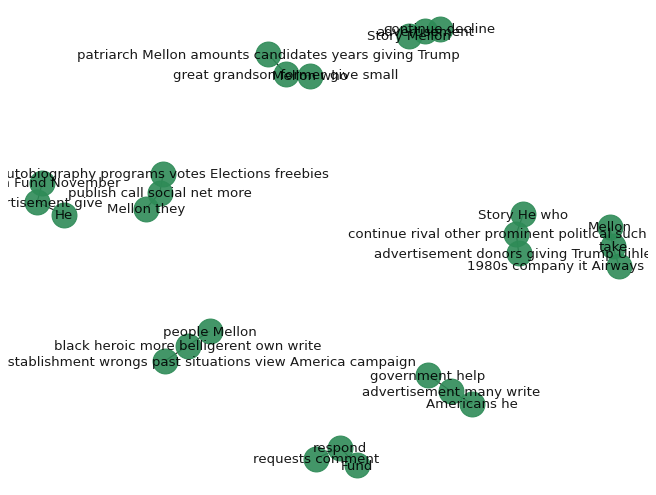

In [ ]:
printGraph(triples)  